This is the first notebook for quantification of FISH expression. In here we quantify intensity in 
various forms (histograms of spot intensities, spot sizes and summed spot intensities).
We also quantify the SNR, the signal to noise ratio and the background.


Jacques Bourg @ Florian Muller lab. Institut Pasteur.

<img src="./pipeline.png" alt="pipeline" width="1200" height="477">

In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import napari

import ipywidgets as widgets
from IPython.display import display

In [2]:
%load_ext autoreload
%autoreload 2

base_dir = Path("../../pipeline/src").resolve()
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "utils"))
sys.path.append(str(base_dir / "detection_fish"))
sys.path.append(str(base_dir / "segmentation"))
sys.path.append(str(base_dir / "synthesis"))

from utils.parameters_tracking import Parameter_tracking as Track
from utils.plots import Plots
from utils.file_handling import FileProcessor
from segmentation.refine_seg import Segmentation
from synthesis.synthesize import Synthesis

tk  = Track()
sg  = Segmentation()
pt  = Plots()
st  = Synthesis()
fp  = FileProcessor()

In [3]:
var = str(Path('../Analysis'))
batch_folders = os.listdir(var)
dropdown = widgets.Dropdown(options=batch_folders, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('SABER',), value='SAB…

In [4]:
n         = np.where(np.array(batch_folders) == dropdown.value)[0][0]
file_path = str(Path(var) / Path(batch_folders[n]) / Path(batch_folders[n] +'.json'))
constants = tk.load_json(file_path)
batch_name= constants['BATCH_NAME']

In [5]:
modalities = constants['MODALITIES']
dropdown2 = widgets.Dropdown(options=modalities, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown2)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('SABER', 'SABER_X8'),…

In [6]:
n2  = np.where(np.array(modalities) == dropdown2.value)[0][0]
modality = modalities[n2]; print(modality)

SABER


In [7]:
channels_cell = constants['CHANNELS'] # DAPI doesn't make sense
dropdown3 = widgets.Dropdown(options=channels_cell, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'));
display(dropdown3)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'FISH'), valu…

In [8]:
n3     = np.where(np.array(channels_cell) == dropdown3.value)[0][0]
chan_c = channels_cell[n3]
print(chan_c)
col_channels = constants['COLORS']  # associated color to this channel
color        = col_channels[n3]; print(color)

FISH
green


In [9]:
detection_methods = ['UFISH','BIGFISH']  # choose bigfish for this one
dropdown4         = widgets.Dropdown(options=detection_methods, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown4)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('UFISH', 'BIGFISH'), …

In [10]:
n4     = np.where(np.array(detection_methods) == dropdown4.value)[0][0]
method = detection_methods[n4]; print(method)

BIGFISH


In [11]:
folder_path_figures = Path(f"../Analysis/{batch_name}/Figures") # create folder for figures (all figures will be stored there)
if not folder_path_figures.exists():
    folder_path_figures.mkdir(parents=True)

#### Spot intensity: extract intensity, spot size, summed spot intensity over estimated size.

In [12]:
batch_fish         = constants[f'BATCH_{modality}_{chan_c}']

dots_path          = constants[f'DOTS_{method}_{modality}_{chan_c}_PATH']
dict_dots          = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

window_size        = 7      # This parameter is critical
n_int_points       = 11
median_filt_size   = 4
frac               = 0.25   # This parameter is critical. 
#   Anyhow validate visually afterwards with the napari window. Iterate until the dot size estimation makes sense visually.

voxel_size_z       = constants[f'VOXEL_SIZE_NM_BF_{modality}_{chan_c}_Z'] 
voxel_size_yx      = constants[f'VOXEL_SIZE_NM_BF_{modality}_{chan_c}_YX']
obj_rad_z          = constants[f'OBJECT_RADIUS_NM_BF{modality}_{chan_c}_Z']
obj_rad_yx         = constants[f'OBJECT_RADIUS_NM_BF{modality}_{chan_c}_YX']

voxel_size_nm      = (voxel_size_z, voxel_size_yx, voxel_size_yx)  # important parameter: might be seen opening the image information in fiji or loooking at the microscope metadata.
object_radius_nm   = (obj_rad_z, obj_rad_yx, obj_rad_yx) #(obj_rad_z*5, obj_rad_yx*5, obj_rad_yx*5)

Batch processing

In [ ]:
for ind_l, file in enumerate(batch_fish):
    im_rna                   = io.imread(Path(file))   
    file_name                = Path(file).stem     
    filebase_name            = '_'.join(file_name.split('_')[:-1])

    df_spots_filt            = dict_dots[filebase_name]
    df_w_intensity           = sg.extract_intensities_df(df_spots_filt, im_rna)  
    df_w_frac_signal         = sg.determine_spots_width_frac_signal_df(im_rna, df_w_intensity, h_window=window_size, size_median_filt=median_filt_size, frac=frac)
    df_w_sum_intensity       = sg.compute_sum_spot_intensity_df(df_w_frac_signal, im_rna)
    df_w_snr_back            = st.compute_snr_df(im_rna, df_w_sum_intensity, voxel_size_nm, object_radius_nm)        
    dict_dots[filebase_name] = df_w_snr_back
                    
fp.save_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'], dict_dots, im_rna.ndim)

#### Manual step      (WARNING: Manual input required)
Organize your batch in rows and columns: rows can be conditions, and columns time or rows can be repetitions and columns conditions
store as (line, column) for each element of the batch. Put None in case you don't want to display it. 
For instance if your batch files is ['file_control0', 'file_control1', 'file_control2', 'file_rep1_c1', 'file_rep2_c1', 'file_rep1_c2', 'file_rep2_c2'] and you want to organize your 
display as:

|          | Concentration 1 | Concentration 2 |
|----------|----------|----------|
| **Rep 1**| R1, C1   | R1, C2   | 
| **Rep 2**| R2, C1   | R2, C2   |


Then, insert the coordinates, in the following way,  do for a batch of experiments like:

batch      = [`Exp to discard`, `Exp to discard`, `Exp to discard`, `R1,C1`, `R2,C1`,`R1,C2`,  `R2,C2` ]

batch_plot = [`None` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,  `None`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,  `None `&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,`(0,0) `,`(1,0) `,`(0,1) `,`(1,1)`]

# PLOTS SABER  1X1, ....

In [13]:
# load the dots once you run the previous cell one time.

dict_dots = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'] )

In [15]:
leg_x = ['1X1X', '1X2X', '3X1X','3X2X','30X1X','30X2X']
leg_y = ['rep 1', 'rep 2', 'rep 3']
name  = f'{modality}_{chan_c}_{method}'

lines = len(leg_y)
cols  = len(leg_x)

print([Path(el).stem for el in batch_fish])
batch_plot = [(0,0), (1,0), (2,0), (0,1), (1,1), (2,1), (0, 2), (1, 2), (2, 2), (0, 3), (1, 3), (2, 3), (0, 4), (1, 4), (2, 4), (0, 5), (1, 5), (2, 5)] # batch_pot has the same dimension as batch.

batch_subselection = [1 if el is not None else 0 for el in batch_plot]           # given the choice made before, we will only plot those files.
batch_subgroup     = [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]            # subgroups to aggregate the data  

['1X1X_2_MMStack_1-Pos000_000.ome_FISH', '1X1X_4_MMStack_Pos0.ome_FISH', '1X1X_5_MMStack_Pos0.ome_FISH', '1X2X_1_MMStack_Pos0.ome_FISH', '1X2X_2_MMStack_Pos0.ome_FISH', '1X2X_4_MMStack_Pos0.ome_FISH', '3X1X_1_MMStack_Pos0.ome_FISH', '3X1X_3_MMStack_Pos0.ome_FISH', '3X1X_4_MMStack_Pos0.ome_FISH', '3X2X_1_MMStack_Pos0.ome_FISH', '3X2X_2_MMStack_Pos0.ome_FISH', '3X2X_3_MMStack_Pos0.ome_FISH', '30X1X_1_MMStack_Pos0.ome_FISH', '30X1X_2_MMStack_Pos0.ome_FISH', '30X1X_3_MMStack_Pos0.ome_FISH', '30X2X_1_MMStack_Pos0.ome_FISH', '30X2X_2_MMStack_Pos0.ome_FISH', '30X2X_3_MMStack_Pos0.ome_FISH']


In [16]:
# data aggregation:
labels_data        = ['1X1X', '1X2X', '3X1X','3X2X','30X1X','30X2X']
labels_data_w_rep  = ['1X1X','1X1X','1X1X','1X2X','1X2X','1X2X','3X1X','3X1X','3X1X','3X2X','3X2X','3X2X','30X1X','30X1X','30X1X','30X2X','30X2X','30X2X']
labels_data_num    = ['1X1X_1','1X1X_2','1X1X_3',
                      '1X2X_1','1X2X_2','1X2X_3',
                      '3X1X_1','3X1X_2','3X1X_3',
                      '3X2X_1','3X2X_2','3X2X_3',
                      '30X1X_1','30X1X_2','30X1X_3',
                      '30X2X_1','30X2X_2','30X2X_3']

dict_dots          = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])
dict_agg_data_int  = {label: [] for label in labels_data}
dict_agg_data_back = {label: [] for label in labels_data}
dict_agg_data_diff = {label: [] for label in labels_data}
dict_int           = {}

for ind, file in enumerate(batch_fish):
    if batch_subselection[ind]:
        filebase_name = '_'.join(Path(file).stem.split('_')[:-1])
        ind_l, ind_c  = batch_plot[ind]
        df            = dict_dots[filebase_name]
        
        intensity     = df['intensity'].to_numpy()
        intensity     = intensity[~np.isnan(intensity)]
        dict_agg_data_int[labels_data_w_rep[ind]].extend(intensity.tolist())
        
        back          = df['background'].to_numpy()
        back          = back[~np.isnan(back)]
        dict_agg_data_back[labels_data_w_rep[ind]].extend(back.tolist())

        diff          = (df['intensity']- df['background']).to_numpy()
        diff          = diff[~np.isnan(diff)]
        dict_agg_data_diff[labels_data_w_rep[ind]].extend(diff.tolist())
        
        dict_int[labels_data_num[ind]] = np.array(intensity, dtype=float)

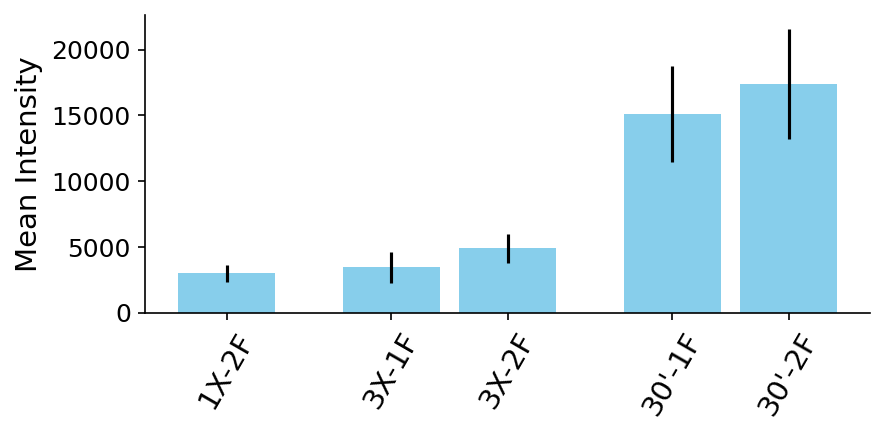

In [17]:
dict_agg_data_diff_copy =  dict_agg_data_int.copy() #   dict_agg_data_diff.copy()
del dict_agg_data_diff_copy['1X1X'] 
labels_data  = list(dict_agg_data_diff_copy.keys()) 
 
means_I = [np.mean(el) for el in dict_agg_data_diff_copy.values()]
std_I   = [np.std(el) for el in dict_agg_data_diff_copy.values()]

val   = [el for el in range(len(means_I))]
dx    = 0.6
dX    = 0.85
x_positions = [ dx,  dx +dX,  2*dx +dX,  2*dx +2*dX, 3*dx +2*dX]

fig, ax = plt.subplots(figsize=(6, 3), dpi = 150)
ax.bar(x_positions, means_I, yerr=std_I, color='skyblue', width=0.5);
ax.set_xticks(x_positions)
ax.set_xticklabels(['1X-2F', '3X-1F','3X-2F', "30'-1F","30'-2F"], fontsize=14, rotation=60);
ax.set_ylabel('Mean Intensity', fontsize=14); # - Background'

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.yticks(fontsize=12);
fig.tight_layout()
 